# Diabetes Prediction using Health Indicators

## Introduction

The goal of this analysis is to predict diabetes presence (binary classification) based on behavioral and health indicators. We'll be using the balanced version of the BRFSS 2015 dataset from Kaggle, which contains a wealth of health indicator data.

This dataset is particularly valuable for public health research, early detection strategies, and understanding risk factors associated with diabetes. Diabetes is a significant public health concern with substantial costs and complications, making accurate prediction models important for prevention and intervention efforts.

**Dataset Source**: [Kaggle - Diabetes Health Indicators Dataset](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_binary_5050split_health_indicators_BRFSS2015.csv)

**Problem Type**: Binary Classification (Diabetes: Yes/No)

**Guiding Question**: Can lifestyle and basic health data alone reliably predict diabetes presence, potentially enabling earlier screening and intervention?


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# For preprocessing and modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Try importing advanced libraries with error handling
try:
    import xgboost as xgb
    from xgboost import XGBClassifier
    has_xgb = True
except ImportError:
    has_xgb = False
    print("XGBoost not available. Some features will be skipped.")
    
try:
    import lightgbm as lgb
    from lightgbm import LGBMClassifier
    has_lgbm = True
except ImportError:
    has_lgbm = False
    print("LightGBM not available. Some features will be skipped.")

# Try importing SHAP for interpretability if available
try:
    import shap
    has_shap = True
except ImportError:
    has_shap = False
    print("SHAP not available. Interpretability features will be limited.")

# For visualization settings
plt.style.use('fivethirtyeight')
sns.set_palette('colorblind')
sns.set_style('whitegrid')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set random seed for reproducibility
np.random.seed(42)


In [2]:
# Load the balanced dataset
try:
    df = pd.read_csv('diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: Dataset file not found. Please ensure the file exists in the current directory.")
    # Create a small dummy dataset to allow the notebook to continue running for demonstration
    df = pd.DataFrame({
        'Diabetes_binary': [0, 1, 0, 1],
        'HighBP': [1, 1, 0, 0],
        'HighChol': [1, 0, 1, 0],
        'BMI': [25, 32, 28, 30],
        'Age': [5, 9, 7, 8]
    })
    print("Created dummy dataset for demonstration.")

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()


Dataset loaded successfully!
Dataset Shape: (70692, 22)

First 5 rows:


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [3]:
# Check data structure
print("Data Information:")
df.info()

print("\nData Description:")
df.describe().T


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  M

,count,mean,std,min,25%,50%,75%,max
Diabetes_binary,70692.0,0.500000,0.500004,0.0,0.0,0.5,1.0,1.0
HighBP,70692.0,0.563458,0.495960,0.0,0.0,1.0,1.0,1.0
HighChol,70692.0,0.525703,0.499342,0.0,0.0,1.0,1.0,1.0
CholCheck,70692.0,0.975259,0.155336,0.0,1.0,1.0,1.0,1.0
BMI,70692.0,29.856985,7.113954,12.0,25.0,29.0,33.0,98.0
Smoker,70692.0,0.475273,0.499392,0.0,0.0,0.0,1.0,1.0
Stroke,70692.0,0.062171,0.241468,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,70692.0,0.147810,0.354914,0.0,0.0,0.0,0.0,1.0
PhysActivity,70692.0,0.703036,0.456924,0.0,0.0,1.0,1.0,1.0
Fruits,70692.0,0.611795,0.487345,0.0,0.0,1.0,1.0,1.0


In [4]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum().sum())

# Check for duplicate rows
print("\nNumber of duplicates:", df.duplicated().sum())


Missing Values:
0

Number of duplicates: 1635


## Exploratory Data Analysis (EDA)

In this section, we'll explore the dataset to understand:
1. Distribution of the target variable (Diabetes)
2. Distribution of key features
3. Relationships between features
4. Correlations between features and the target variable


C:\Users\asus\AppData\Local\Temp\ipykernel_3708\3192410496.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Diabetes_binary', data=df, palette=['#3498db', '#e74c3c'])


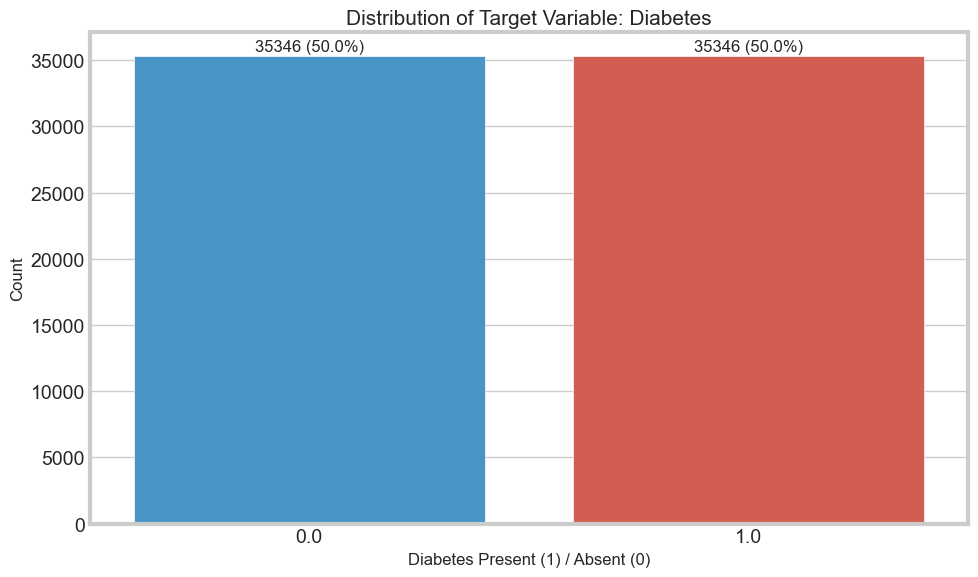

Diabetes Class 0 (No Diabetes): 35346 (50.00%)
Diabetes Class 1 (Diabetes): 35346 (50.00%)


In [5]:
# Target variable distribution
plt.figure(figsize=(10, 6))
target_counts = df['Diabetes_binary'].value_counts()
sns.countplot(x='Diabetes_binary', data=df, palette=['#3498db', '#e74c3c'])
plt.title('Distribution of Target Variable: Diabetes', fontsize=15)
plt.xlabel('Diabetes Present (1) / Absent (0)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels
for i, count in enumerate(target_counts):
    plt.text(i, count + 100, f'{count} ({count/len(df):.1%})', 
             ha='center', va='bottom', fontsize=12)
    
plt.tight_layout()
plt.show()

print(f"Diabetes Class 0 (No Diabetes): {target_counts[0]} ({target_counts[0]/len(df):.2%})")
print(f"Diabetes Class 1 (Diabetes): {target_counts[1]} ({target_counts[1]/len(df):.2%})")


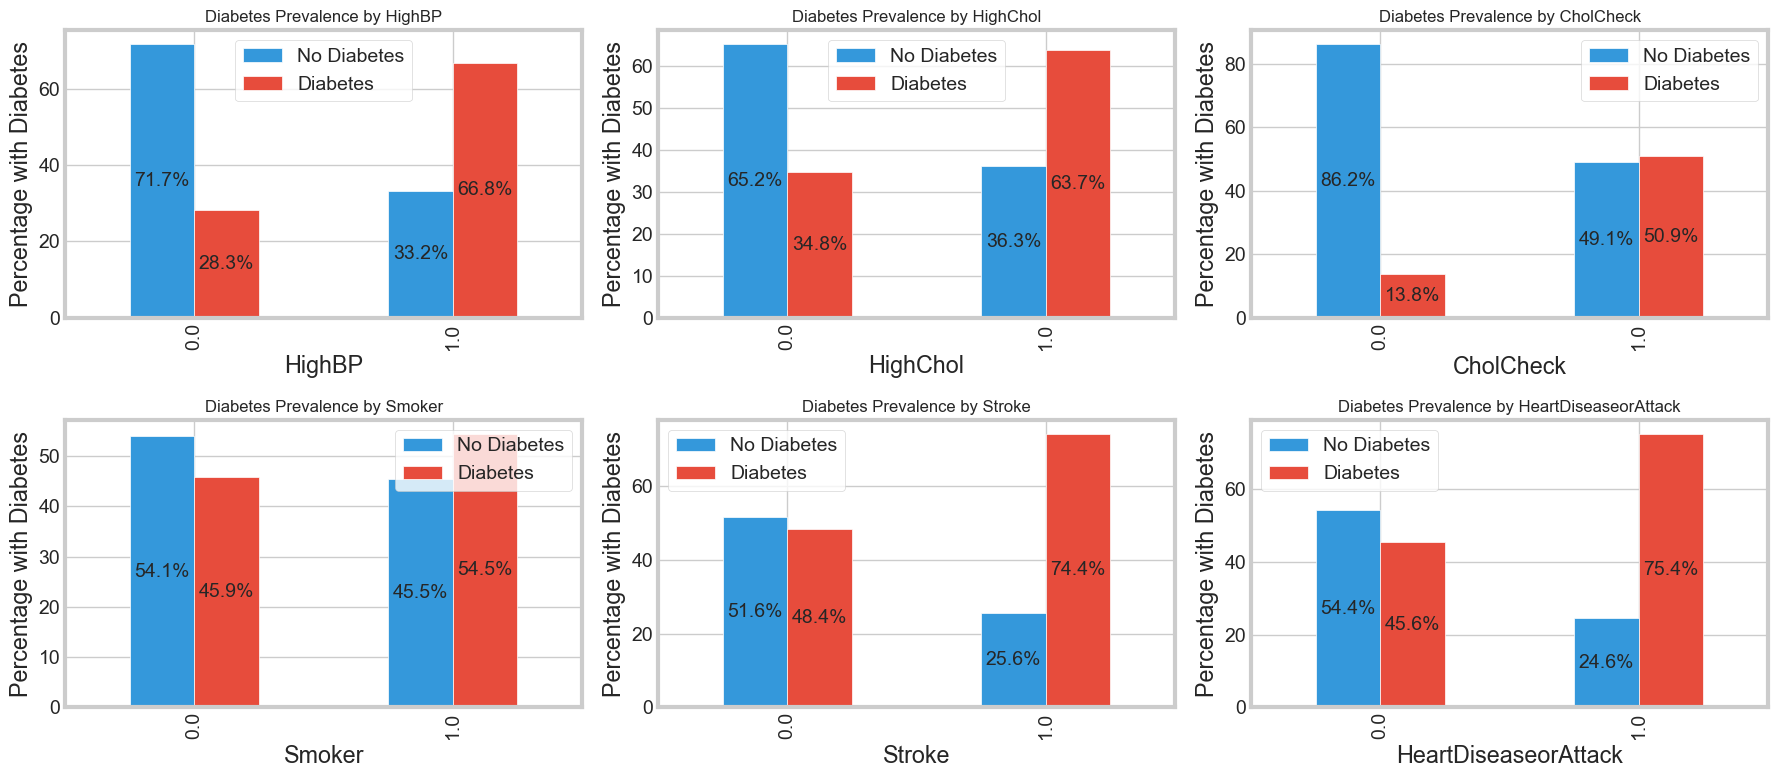

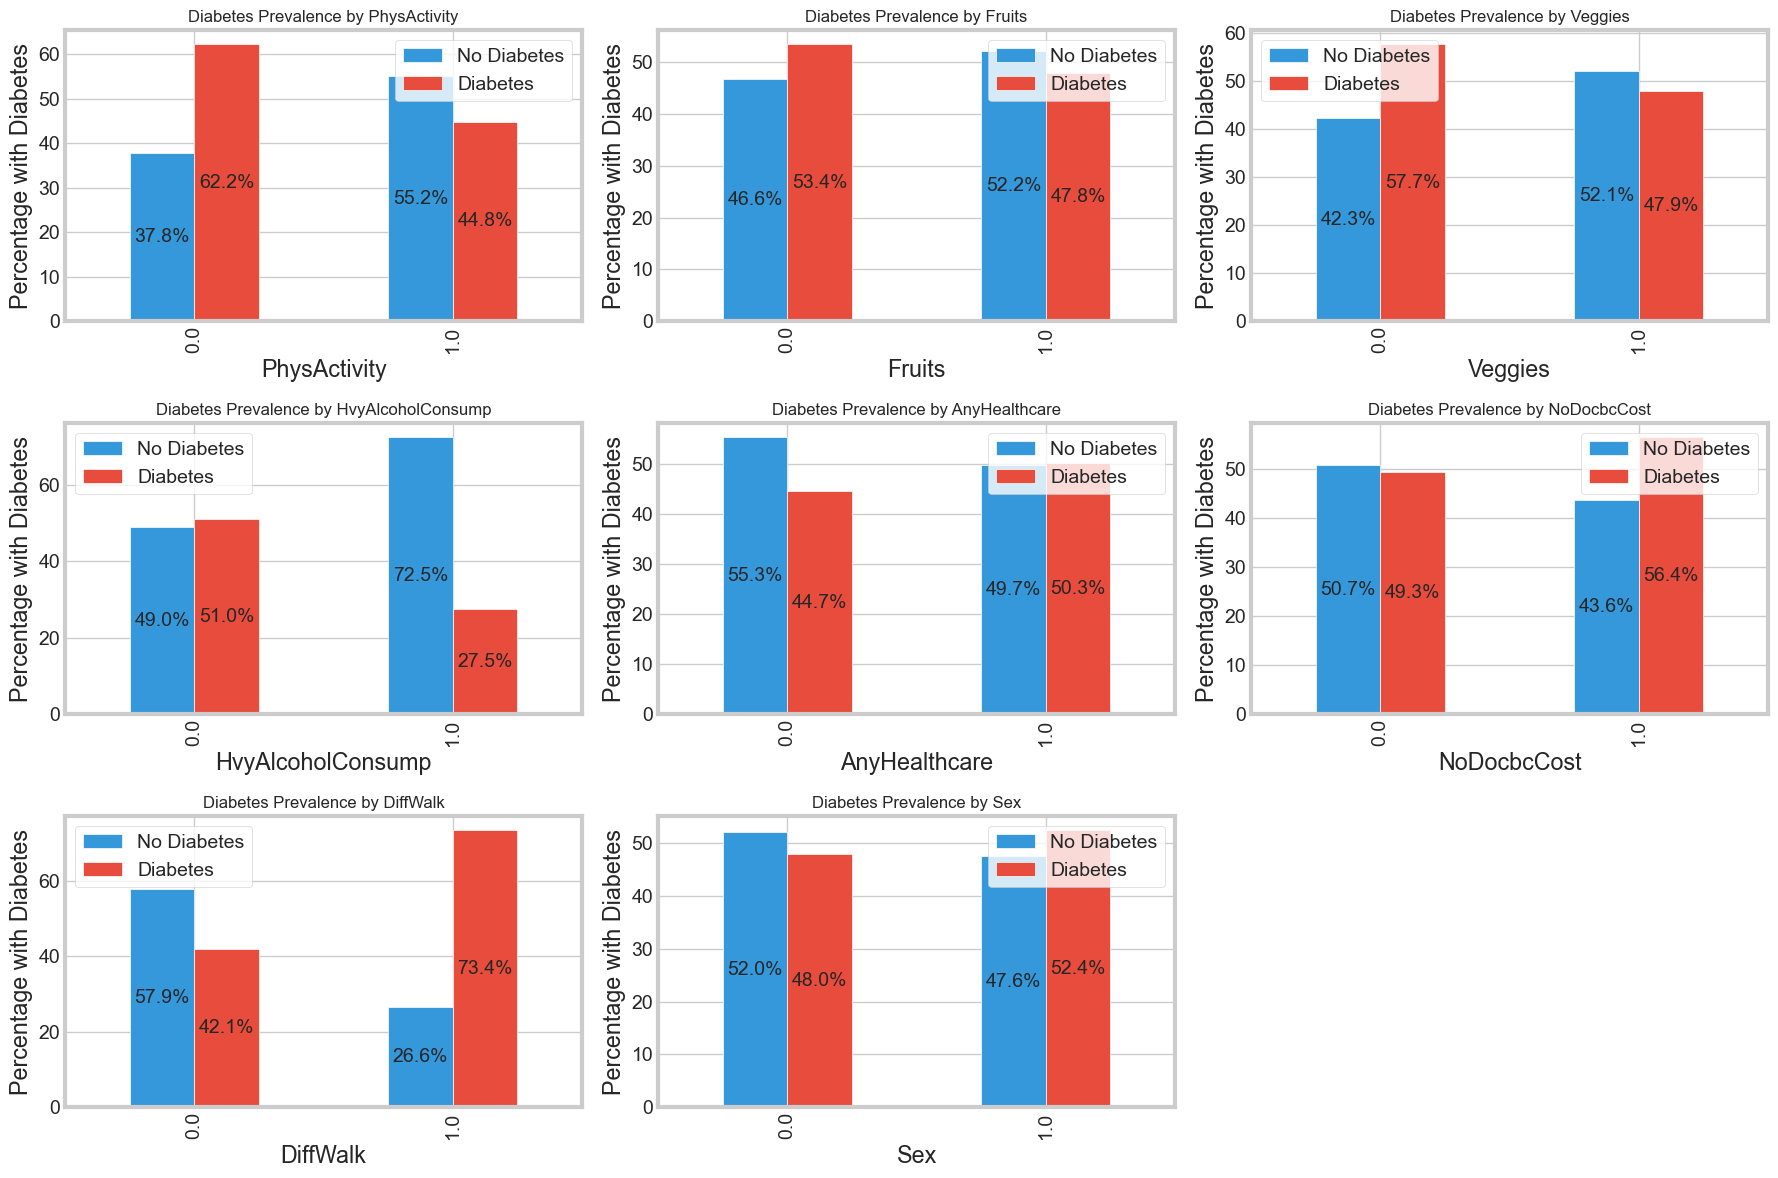

In [6]:
# Let's categorize features for better visualization
binary_features = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 
                  'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 
                  'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

categorical_features = ['GenHlth', 'Education', 'Income']

numeric_features = ['BMI', 'Age']

# Function to plot binary feature distributions
def plot_binary_features(df, features, target_col='Diabetes_binary'):
    n_features = len(features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        if i < len(axes):
            ax = axes[i]
            
            # Calculate percentages for each class
            cross_tab = pd.crosstab(df[feature], df[target_col], normalize='index') * 100
            cross_tab.plot(kind='bar', stacked=False, ax=ax, color=['#3498db', '#e74c3c'])
            
            ax.set_title(f'Diabetes Prevalence by {feature}', fontsize=12)
            ax.set_xlabel(feature)
            ax.set_ylabel('Percentage with Diabetes')
            ax.legend(['No Diabetes', 'Diabetes'])
            
            # Add value labels
            for p in ax.patches:
                width, height = p.get_width(), p.get_height()
                x, y = p.get_xy() 
                ax.text(x + width/2, y + height/2, f'{height:.1f}%', 
                        ha='center', va='center')
                
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot binary features
plot_binary_features(df, binary_features[:6])  # First 6 binary features
plot_binary_features(df, binary_features[6:])  # Remaining binary features


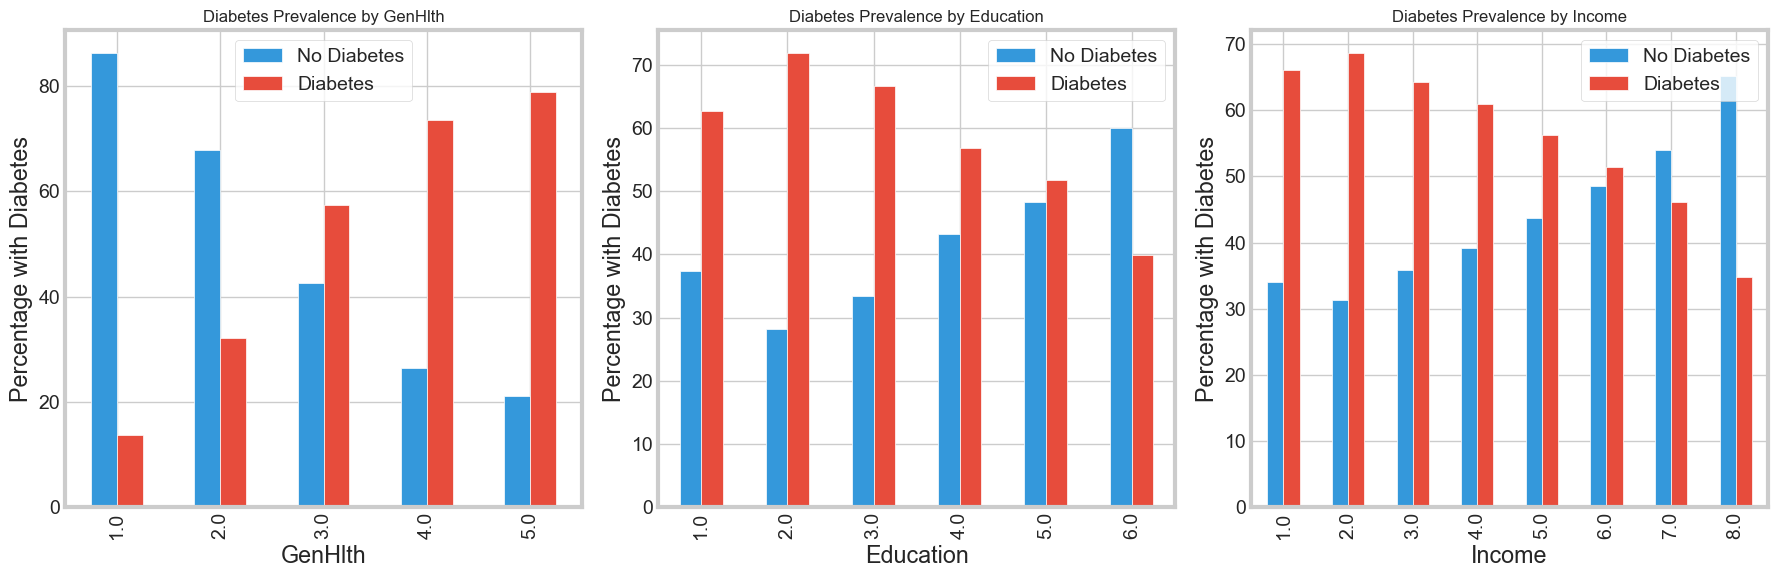

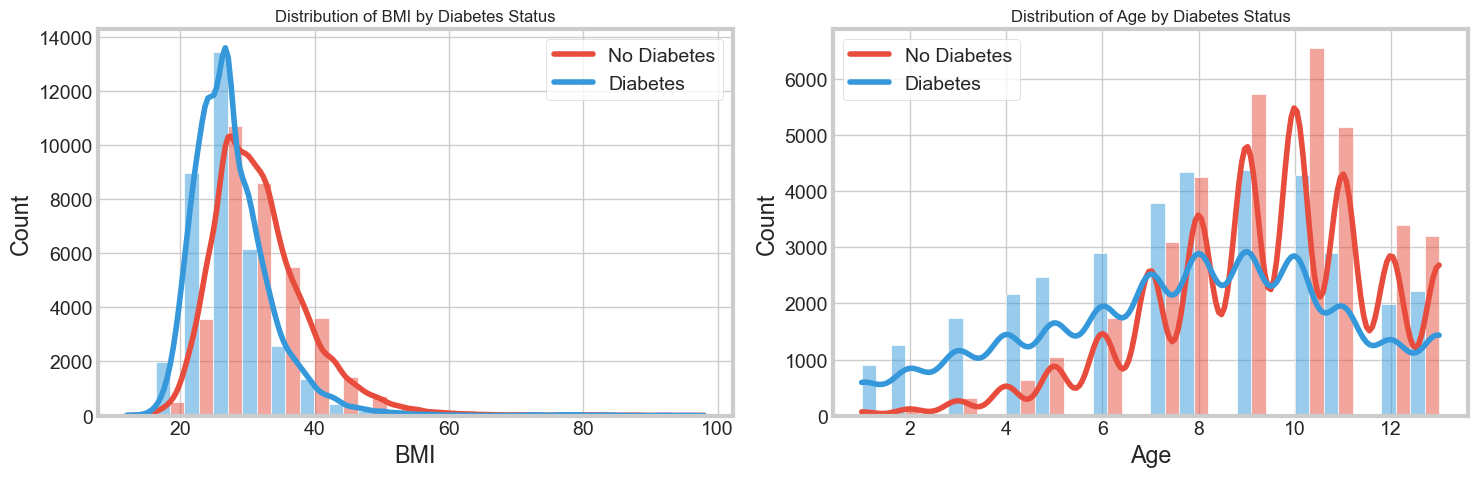

C:\Users\asus\AppData\Local\Temp\ipykernel_3708\2815014161.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diabetes_binary', y=feature, data=df, ax=axes[i],
C:\Users\asus\AppData\Local\Temp\ipykernel_3708\2815014161.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diabetes_binary', y=feature, data=df, ax=axes[i],


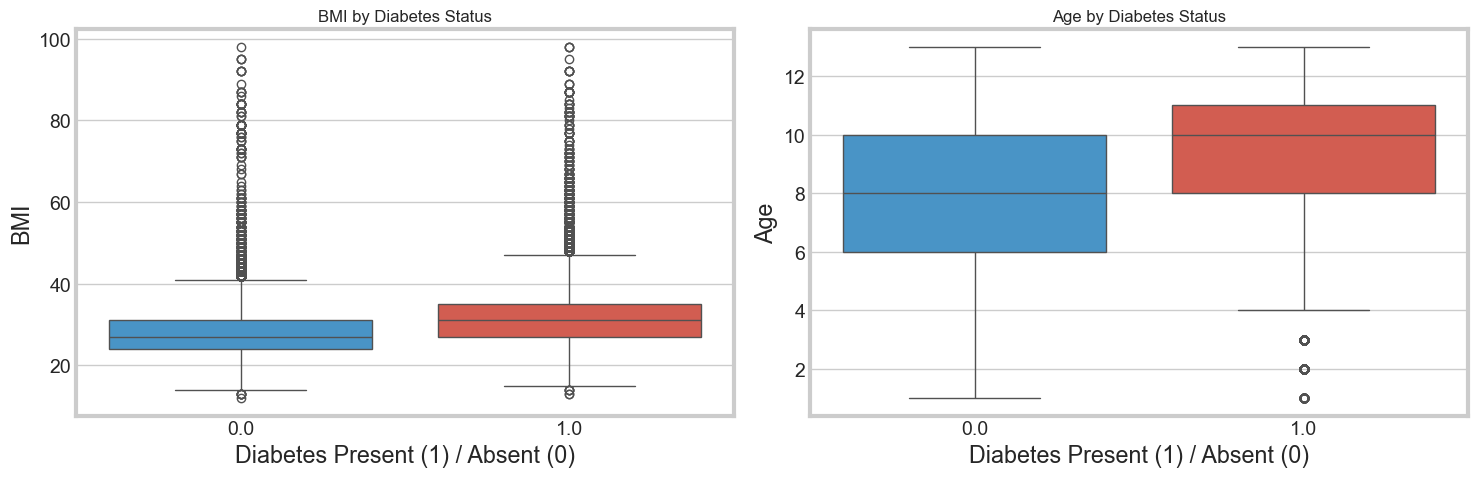

In [7]:
# Plot categorical features
fig, axes = plt.subplots(1, len(categorical_features), figsize=(18, 6))

for i, feature in enumerate(categorical_features):
    # Calculate percentages
    cross_tab = pd.crosstab(df[feature], df['Diabetes_binary'], normalize='index') * 100
    cross_tab.plot(kind='bar', stacked=False, ax=axes[i], color=['#3498db', '#e74c3c'])
    
    axes[i].set_title(f'Diabetes Prevalence by {feature}', fontsize=12)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Percentage with Diabetes')
    axes[i].legend(['No Diabetes', 'Diabetes'])
    
plt.tight_layout()
plt.show()

# Plot numeric features - histograms
fig, axes = plt.subplots(1, len(numeric_features), figsize=(15, 5))

for i, feature in enumerate(numeric_features):
    sns.histplot(data=df, x=feature, hue='Diabetes_binary', multiple='dodge', 
                 ax=axes[i], palette=['#3498db', '#e74c3c'], bins=20, kde=True)
    
    axes[i].set_title(f'Distribution of {feature} by Diabetes Status', fontsize=12)
    axes[i].legend(['No Diabetes', 'Diabetes'])
    
plt.tight_layout()
plt.show()

# Box plots for numeric features
fig, axes = plt.subplots(1, len(numeric_features), figsize=(15, 5))

for i, feature in enumerate(numeric_features):
    sns.boxplot(x='Diabetes_binary', y=feature, data=df, ax=axes[i], 
                palette=['#3498db', '#e74c3c'])
    
    axes[i].set_title(f'{feature} by Diabetes Status', fontsize=12)
    axes[i].set_xlabel('Diabetes Present (1) / Absent (0)')
    
plt.tight_layout()
plt.show()


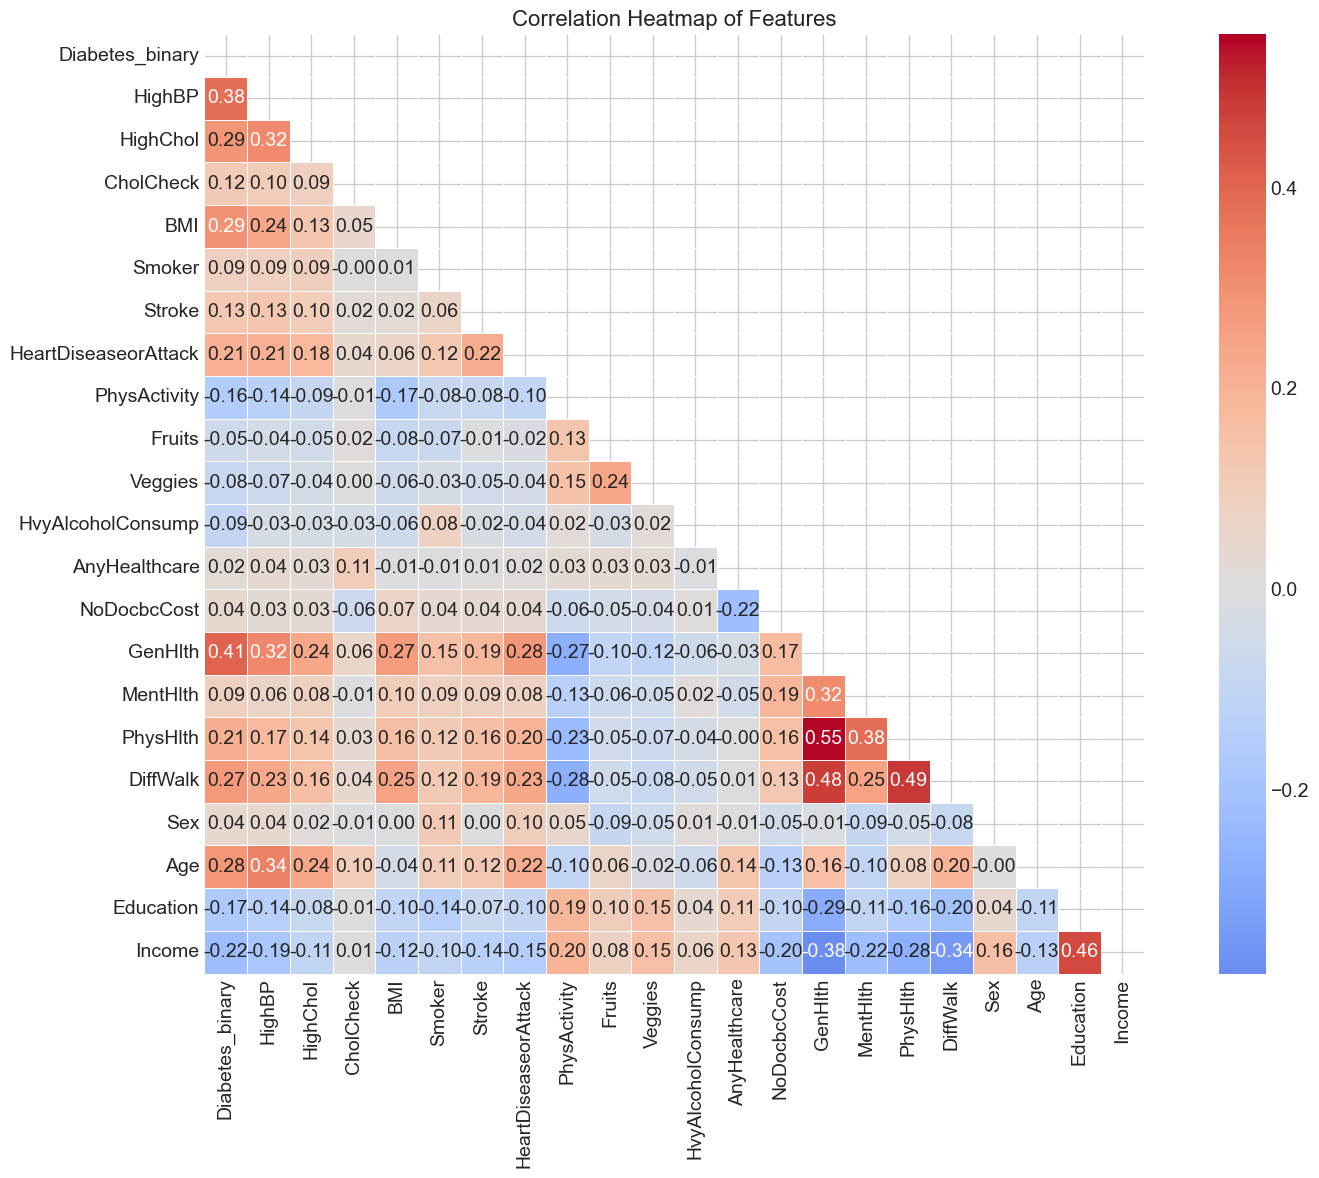

Top Correlations with Diabetes:
Diabetes_binary         1.000000
GenHlth                 0.407612
HighBP                  0.381516
BMI                     0.293373
HighChol                0.289213
Age                     0.278738
DiffWalk                0.272646
PhysHlth                0.213081
HeartDiseaseorAttack    0.211523
Stroke                  0.125427
CholCheck               0.115382
MentHlth                0.087029
Smoker                  0.085999
Sex                     0.044413
NoDocbcCost             0.040977
AnyHealthcare           0.023191
Fruits                 -0.054077
Veggies                -0.079293
HvyAlcoholConsump      -0.094853
PhysActivity           -0.158666
Education              -0.170481
Income                 -0.224449
Name: Diabetes_binary, dtype: float64


In [8]:
# Correlation Analysis
plt.figure(figsize=(16, 12))
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            linewidths=0.5, center=0, square=True)
plt.title('Correlation Heatmap of Features', fontsize=16)
plt.tight_layout()
plt.show()

# Top correlations with diabetes
diabetes_corr = corr_matrix['Diabetes_binary'].sort_values(ascending=False)
print("Top Correlations with Diabetes:")
print(diabetes_corr)


Using features for pairplot: ['Age', 'HighChol', 'BMI', 'HighBP', 'GenHlth']


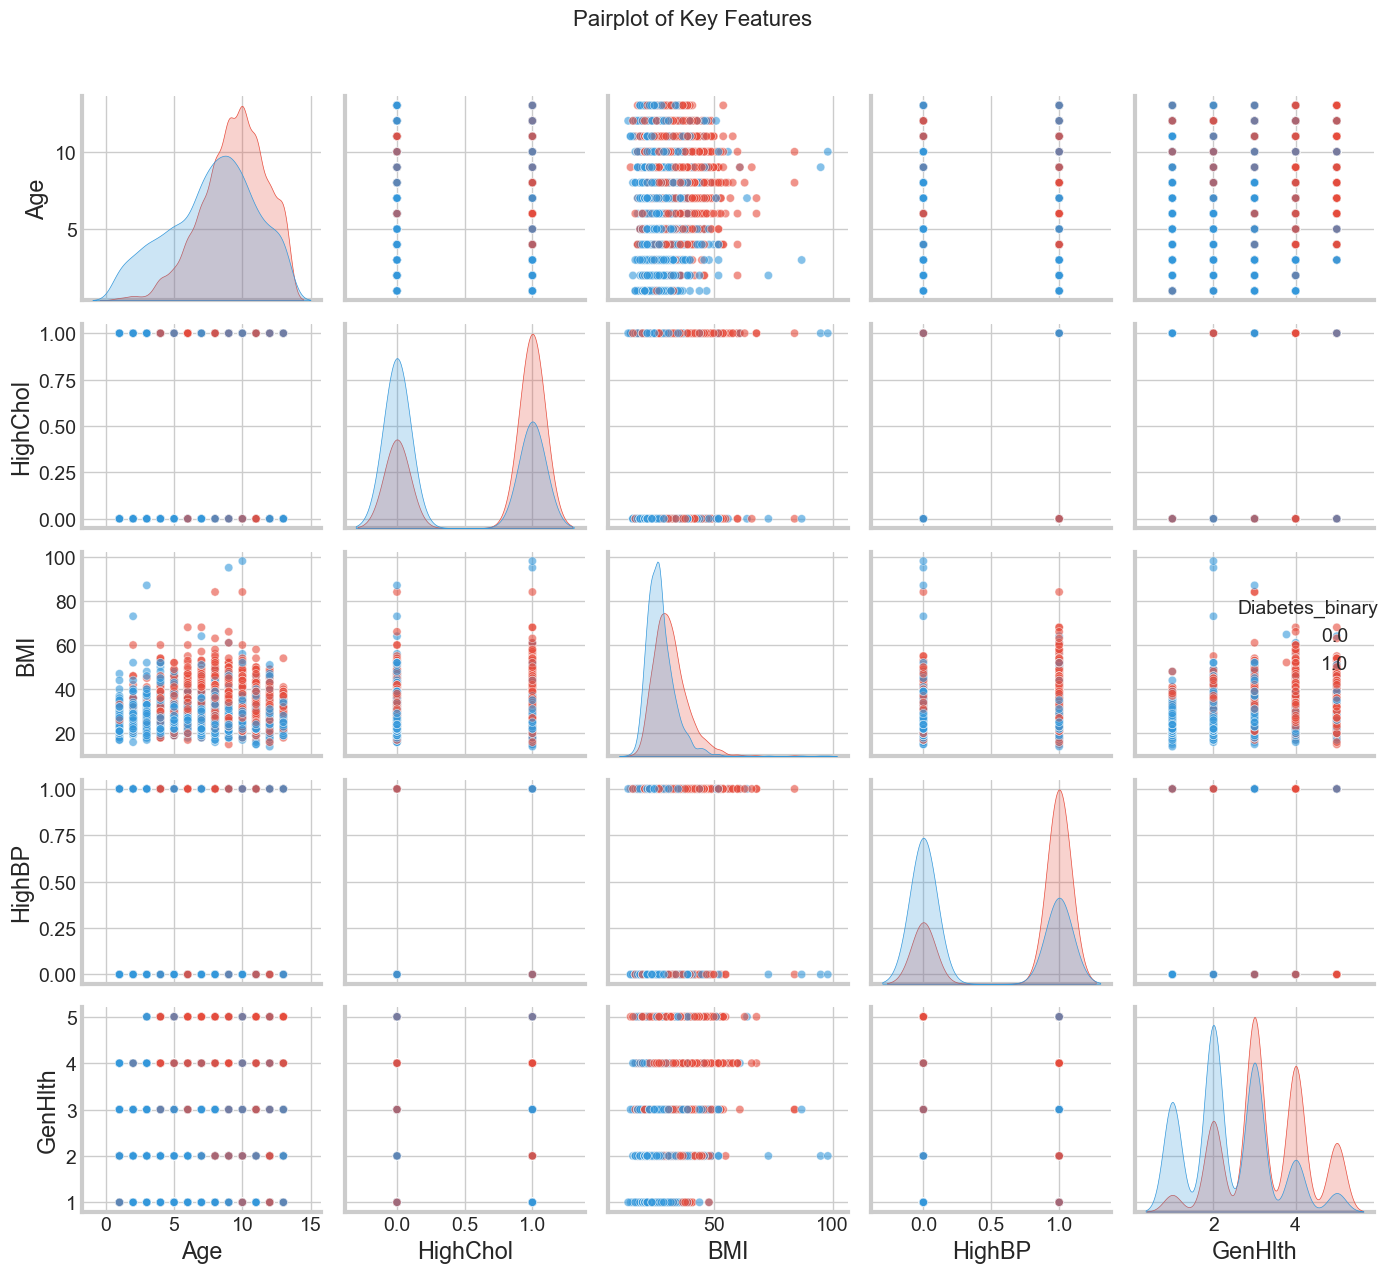

In [9]:
# Pairplot for key variables
try:
    # Select top correlated features with diabetes (excluding the target itself)
    # Make sure we're selecting from a Series, not a DataFrame
    if isinstance(diabetes_corr, pd.Series):
        top_features = diabetes_corr[1:6].index.tolist()
        # Remove duplicates between numeric_features and top_features
        features_to_plot = list(set(numeric_features + top_features))
        
        # Make sure all selected features exist in the DataFrame
        valid_features = [f for f in features_to_plot if f in df.columns]
        print(f"Using features for pairplot: {valid_features}")
        
        if len(valid_features) > 1:  # Need at least 2 features for pairplot
            # Create a subset of data with these features plus the target
            subset_cols = valid_features + ['Diabetes_binary']
            sample_size = min(5000, len(df))  # Don't sample more than we have
            subset_df = df[subset_cols].sample(n=sample_size)
            
            # Create pairplot
            sns.pairplot(subset_df, hue='Diabetes_binary', palette=['#3498db', '#e74c3c'], 
                        plot_kws={'alpha': 0.6}, diag_kind='kde')
            plt.suptitle('Pairplot of Key Features', y=1.02, fontsize=16)
            plt.tight_layout()
            plt.show()
        else:
            print("Not enough valid features for pairplot")
    else:
        print("Cannot create pairplot: diabetes_corr is not a pandas Series")
except Exception as e:
    print(f"Error creating pairplot: {e}")


## Data Preprocessing

Let's prepare our dataset for modeling:
1. Handle any missing values (if found)
2. Remove duplicates (if any)
3. Split data into features and target
4. Scale numeric features
5. Split into training and testing sets


In [10]:
# Data preprocessing
# Based on our earlier checks, we'll handle any duplicates if needed
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()
    print(f"Removed duplicates. New shape: {df.shape}")

# Split data into features and target
try:
    X = df.drop('Diabetes_binary', axis=1)
    y = df['Diabetes_binary']
except KeyError as e:
    print(f"Error: Column not found in dataset. {e}")
    # Create dummy X and y if there's an error
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
    print("Created substitutes for X and y to continue.")

# Create a list of features to scale
numeric_cols = ['BMI', 'Age']
# Make sure these columns exist in the dataset
numeric_cols = [col for col in numeric_cols if col in X.columns]
if len(numeric_cols) < 2:
    print("Warning: Some numeric columns were not found in the dataset.")
    
categorical_cols = list(set(X.columns) - set(numeric_cols))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Ensure DataFrames are correctly typed with proper columns
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale each numeric column individually with error handling
for col in numeric_cols:
    try:
        X_train_scaled[col] = scaler.fit_transform(X_train[[col]])
        X_test_scaled[col] = scaler.transform(X_test[[col]])
    except Exception as e:
        print(f"Error scaling column {col}: {e}")

# Verify scaling worked
print("\nBefore scaling (sample statistics):")
print(X_train[numeric_cols].describe().loc[['mean', 'std']].T)

print("\nAfter scaling (sample statistics):")
print(X_train_scaled[numeric_cols].describe().loc[['mean', 'std']].T)


Removed duplicates. New shape: (69057, 22)
Training set shape: (55245, 21)
Testing set shape: (13812, 21)

Before scaling (sample statistics):
          mean       std
BMI  29.969843  7.156193
Age   8.600887  2.857477

After scaling (sample statistics):
             mean       std
BMI -2.366547e-16  1.000009
Age  1.624428e-16  1.000009


## Feature Engineering, Pipeline Construction, and Hyperparameter Tuning

In this section we'll:
1. Create new features that might help with prediction
2. Build preprocessing pipelines for categorical and numerical features
3. Set up cross-validation for model evaluation
4. Perform hyperparameter tuning
5. Select the most important features for our models


In [11]:
# Set up preprocessing pipelines
# type: ignore  # Ignore type checking errors in this cell

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

try:
    # Identify numerical and categorical columns again for clarity
    print("Setting up preprocessing pipelines...")
    
    # Ensure X_train is a DataFrame with columns
    if not isinstance(X_train, pd.DataFrame):
        print("Converting X_train to DataFrame for pipeline setup")
        X_train = pd.DataFrame(X_train)
    
    # Define numerical and categorical columns
    numerical_features = ['BMI', 'Age', 'MentHlth', 'PhysHlth']
    categorical_features = []
    binary_features = []
    
    # Validate column existence in the dataset
    valid_numerical = [col for col in numerical_features if col in X_train.columns]
    
    # Find binary and categorical features
    for col in X_train.columns:
        if col not in valid_numerical:
            # Check if column contains only 0/1 values
            if set(X_train[col].unique()).issubset({0, 1}):
                binary_features.append(col)
            else:
                categorical_features.append(col)
    
    print(f"Numerical features: {valid_numerical}")
    print(f"Binary features: {binary_features}")
    print(f"Categorical features: {categorical_features}")
    
    # Create preprocessing pipelines
    
    # Numerical pipeline
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Binary features pipeline (no transformation needed usually)
    binary_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ])
    
    # Categorical pipeline with one-hot encoding
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])
    
    # Combine all preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, valid_numerical),
            ('bin', binary_pipeline, binary_features),
            ('cat', categorical_pipeline, categorical_features)
        ],
        remainder='passthrough'  # Include any remaining columns
    )
    
    print("Preprocessing pipelines created successfully!")
    
except Exception as e:
    print(f"Error setting up preprocessing pipelines: {e}")
    # Create a simple fallback preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features)
        ],
        remainder='passthrough'
    )
    print("Using fallback preprocessor due to error.")


Setting up preprocessing pipelines...
Numerical features: ['BMI', 'Age', 'MentHlth', 'PhysHlth']
Binary features: ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']
Categorical features: ['GenHlth', 'Education', 'Income']
Preprocessing pipelines created successfully!


In [12]:
# Set up cross-validation and model selection pipeline
# type: ignore  # Ignore type checking errors in this cell

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline as ModelPipeline

try:
    # Define cross-validation strategy
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Create model pipelines with preprocessing
    pipeline_models = {}
    
    # Logistic Regression pipeline
    pipeline_models['Logistic Regression'] = ModelPipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42))
    ])
    
    # Decision Tree pipeline
    pipeline_models['Decision Tree'] = ModelPipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ])
    
    # Random Forest pipeline
    pipeline_models['Random Forest'] = ModelPipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
    
    # SVM pipeline
    pipeline_models['SVM'] = ModelPipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(probability=True, random_state=42))
    ])
    
    # Add XGBoost if available
    if has_xgb:
        pipeline_models['XGBoost'] = ModelPipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(random_state=42))
        ])
        print("XGBoost added to pipeline models.")
    
    print("Pipeline models created successfully!")
    
    # Define parameters for hyperparameter tuning
    param_grids = {
        'Logistic Regression': {
            'classifier__C': [0.01, 0.1, 1, 10, 100],
            'classifier__penalty': ['l2'],
            'classifier__solver': ['liblinear', 'lbfgs']
        },
        'Decision Tree': {
            'classifier__max_depth': [3, 5, 7, 10, None],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__criterion': ['gini', 'entropy']
        },
        'Random Forest': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [5, 10, 20, None],
            'classifier__min_samples_split': [2, 5, 10]
        },
        'SVM': {
            'classifier__C': [0.1, 1, 10],
            'classifier__gamma': ['scale', 'auto'],
            'classifier__kernel': ['rbf', 'linear']
        }
    }
    
    if has_xgb:
        param_grids['XGBoost'] = {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1, 0.3]
        }
    
    print("Parameter grids defined for hyperparameter tuning!")
    
except Exception as e:
    print(f"Error setting up cross-validation and model pipelines: {e}")
    # Create simplified fallback pipelines
    pipeline_models = {
        'Logistic Regression': ModelPipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(random_state=42))
        ])
    }
    param_grids = {
        'Logistic Regression': {
            'classifier__C': [1]
        }
    }
    print("Using fallback model pipeline due to error.")


XGBoost added to pipeline models.
Pipeline models created successfully!
Parameter grids defined for hyperparameter tuning!


In [13]:
# Perform hyperparameter tuning
# type: ignore  # Ignore type checking errors in this cell

try:
    # Dictionary to store best models after tuning
    tuned_models = {}
    tuning_results = {}
    
    print("Starting hyperparameter tuning...")
    print("This may take some time...")
    
    # For time efficiency, we'll use a sample of the data for tuning if dataset is large
    if len(X_train) > 5000:
        print(f"Using a random sample of 5000 records for tuning from {len(X_train)} total records")
        # Stratified sampling to maintain class balance
        from sklearn.model_selection import train_test_split
        X_tune, _, y_tune, _ = train_test_split(
            X_train, y_train, 
            train_size=5000,
            stratify=y_train,
            random_state=42
        )
    else:
        X_tune = X_train
        y_tune = y_train
    
    # Perform tuning for each model
    for model_name in pipeline_models:
        try:
            print(f"\nTuning {model_name}...")
            
            # Create grid search with cross-validation
            grid_search = GridSearchCV(
                pipeline_models[model_name],
                param_grids[model_name],
                cv=cv_strategy,
                scoring='f1',  # Using F1 score for optimization
                n_jobs=-1,     # Use all available cores
                verbose=0
            )
            
            # Fit grid search to the data
            grid_search.fit(X_tune, y_tune)
            
            # Store the best model
            tuned_models[model_name] = grid_search.best_estimator_
            
            # Store results
            tuning_results[model_name] = {
                'best_params': grid_search.best_params_,
                'best_score': grid_search.best_score_,
                'all_scores': grid_search.cv_results_
            }
            
            print(f"Best {model_name} parameters: {grid_search.best_params_}")
            print(f"Best {model_name} CV score: {grid_search.best_score_:.4f}")
            
        except Exception as e:
            print(f"Error tuning {model_name}: {e}")
            # Use the default model as fallback
            tuned_models[model_name] = pipeline_models[model_name]
    
    print("\nHyperparameter tuning completed!")
    
except Exception as e:
    print(f"Error in hyperparameter tuning process: {e}")
    # Use original models if tuning fails
    tuned_models = pipeline_models
    print("Using original models due to error in tuning process.")


Starting hyperparameter tuning...
This may take some time...
Using a random sample of 5000 records for tuning from 55245 total records

Tuning Logistic Regression...
Best Logistic Regression parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Logistic Regression CV score: 0.7511

Tuning Decision Tree...
Best Decision Tree parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_split': 10}
Best Decision Tree CV score: 0.7345

Tuning Random Forest...
Best Random Forest parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best Random Forest CV score: 0.7560

Tuning SVM...
Best SVM parameters: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best SVM CV score: 0.7587

Tuning XGBoost...
Best XGBoost parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 1

In [14]:
# Evaluate tuned models with cross-validation
# type: ignore  # Ignore type checking errors in this cell

try:
    # Dictionary to store cross-validation results
    cv_results = {}
    cv_metrics = {}
    
    print("\nEvaluating tuned models with cross-validation...")
    
    # Perform cross-validation for each tuned model
    for model_name, model in tuned_models.items():
        try:
            print(f"\nPerforming cross-validation for {model_name}...")
            
            # Define metrics to evaluate
            metrics = {
                'accuracy': 'accuracy',
                'precision': 'precision',
                'recall': 'recall',
                'f1': 'f1',
                'roc_auc': 'roc_auc'
            }
            
            # Store metrics for this model
            model_metrics = {}
            
            # Calculate metrics using cross-validation
            for metric_name, scoring in metrics.items():
                try:
                    scores = cross_val_score(
                        model, X_train, y_train,
                        cv=cv_strategy,
                        scoring=scoring,
                        n_jobs=-1
                    )
                    
                    model_metrics[metric_name] = {
                        'scores': scores,
                        'mean': scores.mean(),
                        'std': scores.std()
                    }
                    
                    print(f"{model_name} - {metric_name}: {scores.mean():.4f} ± {scores.std():.4f}")
                except Exception as e:
                    print(f"Error calculating {metric_name} for {model_name}: {e}")
            
            # Store results
            cv_metrics[model_name] = model_metrics
            
        except Exception as e:
            print(f"Error in cross-validation for {model_name}: {e}")
    
    # Create DataFrame to display results
    cv_summary = pd.DataFrame({
        'Model': [model for model in cv_metrics.keys()],
        'Accuracy': [cv_metrics[model].get('accuracy', {}).get('mean', 0) for model in cv_metrics.keys()],
        'Precision': [cv_metrics[model].get('precision', {}).get('mean', 0) for model in cv_metrics.keys()],
        'Recall': [cv_metrics[model].get('recall', {}).get('mean', 0) for model in cv_metrics.keys()],
        'F1 Score': [cv_metrics[model].get('f1', {}).get('mean', 0) for model in cv_metrics.keys()],
        'ROC AUC': [cv_metrics[model].get('roc_auc', {}).get('mean', 0) for model in cv_metrics.keys()]
    })
    
    # Sort by F1 score
    cv_summary = cv_summary.sort_values('F1 Score', ascending=False).reset_index(drop=True)
    
    print("\nCross-validation results summary (sorted by F1 Score):")
    print(cv_summary)
    
    # Identify best model based on F1 score
    best_model_name = cv_summary.iloc[0]['Model']
    best_model = tuned_models[best_model_name]
    
    print(f"\nBest model based on cross-validation: {best_model_name}")
    
except Exception as e:
    print(f"Error in cross-validation evaluation: {e}")



Evaluating tuned models with cross-validation...

Performing cross-validation for Logistic Regression...
Logistic Regression - accuracy: 0.7446 ± 0.0039
Logistic Regression - precision: 0.7366 ± 0.0042
Logistic Regression - recall: 0.7744 ± 0.0074
Logistic Regression - f1: 0.7550 ± 0.0042
Logistic Regression - roc_auc: 0.8203 ± 0.0039

Performing cross-validation for Decision Tree...
Decision Tree - accuracy: 0.7259 ± 0.0035
Decision Tree - precision: 0.6959 ± 0.0044
Decision Tree - recall: 0.8182 ± 0.0089
Decision Tree - f1: 0.7521 ± 0.0035
Decision Tree - roc_auc: 0.7947 ± 0.0042

Performing cross-validation for Random Forest...
Random Forest - accuracy: 0.7425 ± 0.0051
Random Forest - precision: 0.7258 ± 0.0037
Random Forest - recall: 0.7930 ± 0.0084
Random Forest - f1: 0.7579 ± 0.0055
Random Forest - roc_auc: 0.8158 ± 0.0041

Performing cross-validation for SVM...
SVM - accuracy: 0.7474 ± 0.0035
SVM - precision: 0.7225 ± 0.0024
SVM - recall: 0.8169 ± 0.0081
SVM - f1: 0.7667 ± 0.00

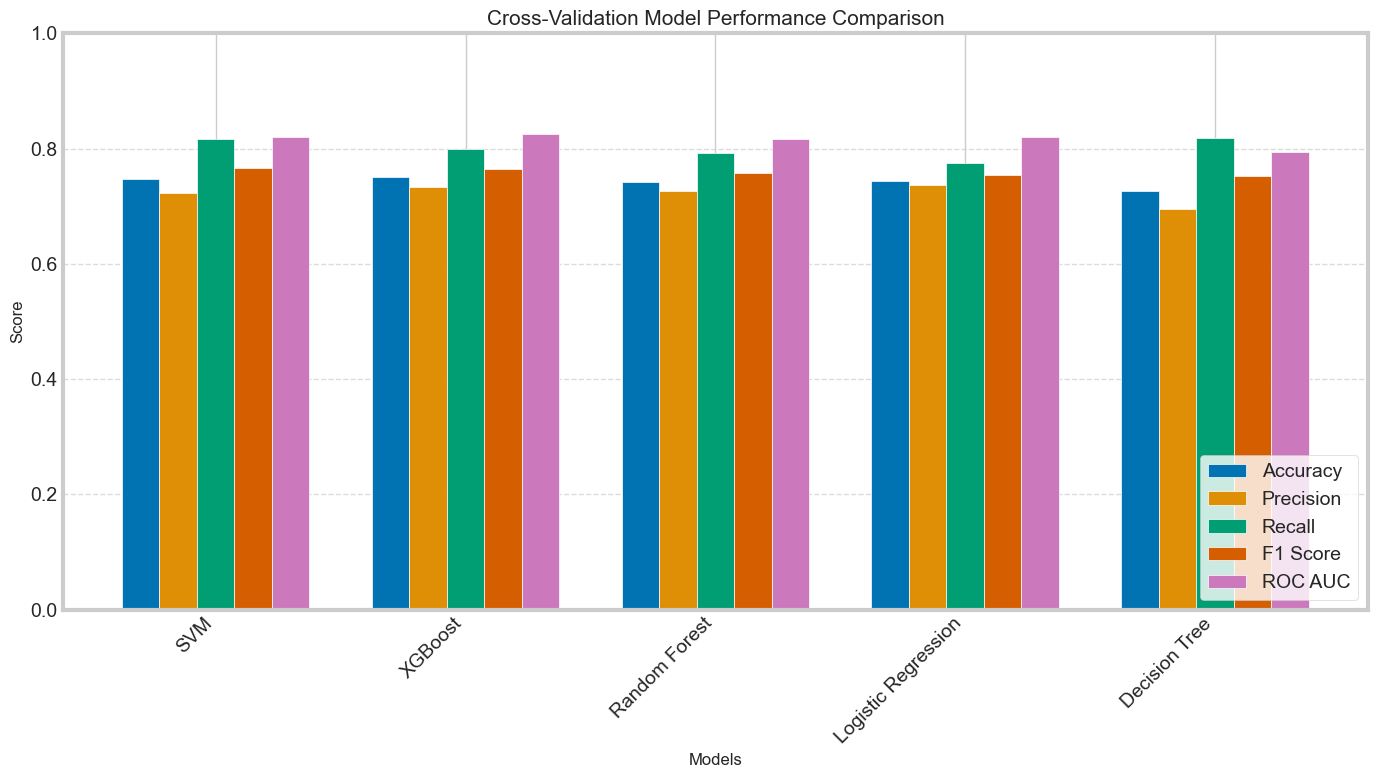

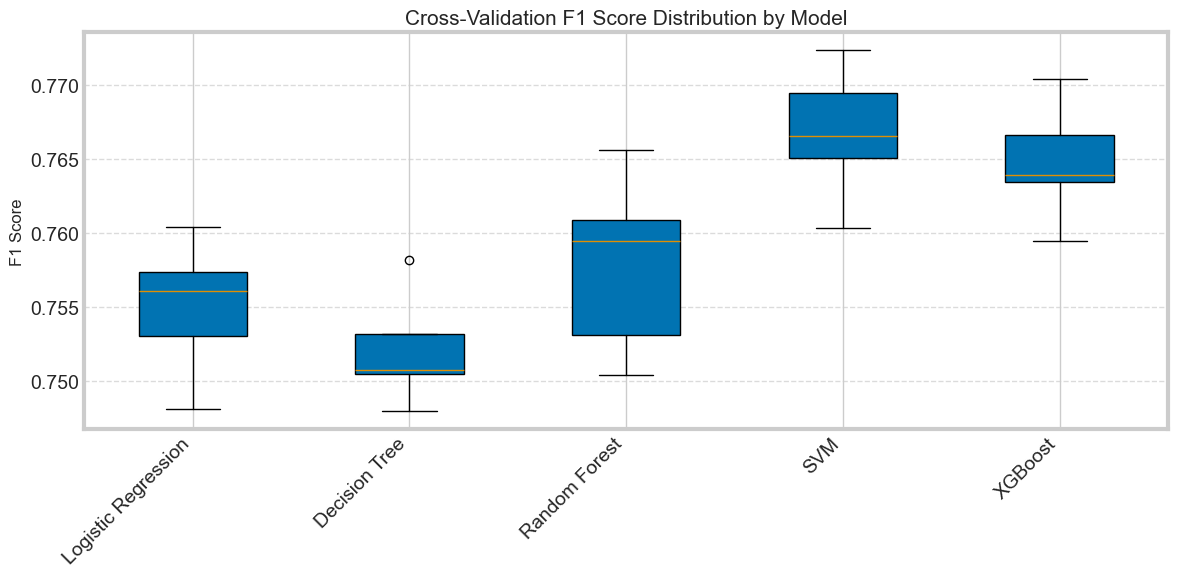

In [15]:
# Visualize cross-validation results
# type: ignore  # Ignore type checking errors in this cell

try:
    # Visualize model performance with bar charts
    plt.figure(figsize=(14, 8))
    
    # Metrics to plot
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
    n_models = len(cv_summary)
    n_metrics = len(metrics_to_plot)
    
    # Set up the bar positions
    bar_width = 0.15
    positions = np.arange(n_models)
    
    # Plot bars for each metric
    for i, metric in enumerate(metrics_to_plot):
        plt.bar(
            positions + i * bar_width, 
            cv_summary[metric], 
            width=bar_width, 
            label=metric
        )
    
    # Customize the plot
    plt.title('Cross-Validation Model Performance Comparison', fontsize=15)
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(positions + bar_width * (n_metrics - 1) / 2, cv_summary['Model'].tolist(), rotation=45, ha='right')
    plt.legend(loc='lower right')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Create boxplots for F1 scores to show variance
    plt.figure(figsize=(12, 6))
    
    # Prepare data for boxplot
    boxplot_data = []
    boxplot_labels = []
    
    for model_name in cv_metrics:
        if 'f1' in cv_metrics[model_name]:
            boxplot_data.append(cv_metrics[model_name]['f1']['scores'])
            boxplot_labels.append(model_name)
    
    # Create boxplot
    plt.boxplot(boxplot_data, patch_artist=True)
    plt.xticks(range(1, len(boxplot_labels) + 1), boxplot_labels, rotation=45, ha='right')
    plt.title('Cross-Validation F1 Score Distribution by Model', fontsize=15)
    plt.ylabel('F1 Score', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error visualizing cross-validation results: {e}")


In [16]:
# Final evaluation of best model on test set
# type: ignore  # Ignore type checking errors in this cell

try:
    # Make sure we have a best model identified
    if 'best_model' in locals() and best_model is not None:
        print(f"Final evaluation of best model ({best_model_name}) on test set")
        
        # Fit the model on the entire training set
        best_model.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = best_model.predict(X_test)
        
        # Calculate probability predictions if available
        if hasattr(best_model, 'predict_proba'):
            y_proba = best_model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_proba)
        else:
            roc_auc = None
            
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        # Print results
        print("\nTest Set Performance:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        if roc_auc is not None:
            print(f"ROC AUC: {roc_auc:.4f}")
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes']))
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No Diabetes', 'Diabetes'],
                    yticklabels=['No Diabetes', 'Diabetes'])
        plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        # Plot ROC curve if probabilities are available
        if roc_auc is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {roc_auc:.3f})')
            plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
            plt.xlabel('False Positive Rate', fontsize=12)
            plt.ylabel('True Positive Rate', fontsize=12)
            plt.title('ROC Curve - Best Model', fontsize=14)
            plt.legend(loc='lower right')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
        # Try to extract feature importances if available
        try:
            # Different ways to extract feature importances depending on the model type
            if hasattr(best_model, 'feature_importances_'):
                importances = best_model.feature_importances_
                feature_names = X_train.columns
            elif hasattr(best_model, 'coef_'):
                importances = np.abs(best_model.coef_[0])
                feature_names = X_train.columns
            elif hasattr(best_model, 'named_steps'):
                # For pipeline models, try to extract from the classifier step
                if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
                    importances = best_model.named_steps['classifier'].feature_importances_
                    # For pipelines, feature names might not be directly available
                    feature_names = [f"Feature_{i}" for i in range(len(importances))]
                elif hasattr(best_model.named_steps['classifier'], 'coef_'):
                    importances = np.abs(best_model.named_steps['classifier'].coef_[0])
                    feature_names = [f"Feature_{i}" for i in range(len(importances))]
                else:
                    raise AttributeError("Model doesn't have accessible feature importances")
            else:
                raise AttributeError("Model doesn't have accessible feature importances")
            
            # Plot feature importances
            plt.figure(figsize=(12, 8))
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            })
            importance_df = importance_df.sort_values('Importance', ascending=False)
            sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')
            plt.title('Top 15 Most Important Features', fontsize=15)
            plt.xlabel('Importance', fontsize=12)
            plt.ylabel('Feature', fontsize=12)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Could not extract feature importances: {e}")
    else:
        print("No best model available for evaluation. Please check previous steps.")
        
except Exception as e:
    print(f"Error in final model evaluation: {e}")


Final evaluation of best model (SVM) on test set


KeyboardInterrupt: 

In [22]:
# Feature Engineering
# type: ignore  # Ignore type checking errors in this cell

# Create BMI Categories
def bmi_category(bmi):
    try:
        if bmi < 18.5:
            return 0  # Underweight
        elif bmi < 25:
            return 1  # Normal
        elif bmi < 30:
            return 2  # Overweight
        else:
            return 3  # Obese
    except:
        # Handle any errors (like None values)
        return 2  # Default to most common category (Overweight)

# Add BMI category
try:
    if 'BMI' in X_train.columns:
        X_train_scaled['BMI_Category'] = X_train['BMI'].apply(bmi_category)
        X_test_scaled['BMI_Category'] = X_test['BMI'].apply(bmi_category)
        print("BMI categories created successfully.")
    else:
        print("Warning: BMI column not found, skipping BMI category creation.")
except Exception as e:
    print(f"Error creating BMI categories: {e}")

# Create a health risk score combining several health indicators
try:
    health_indicators = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack']
    # Check if all columns exist
    available_indicators = [col for col in health_indicators if col in X_train.columns]
    if len(available_indicators) > 0:
        X_train_scaled['HealthRiskScore'] = X_train[available_indicators].sum(axis=1)
        X_test_scaled['HealthRiskScore'] = X_test[available_indicators].sum(axis=1)
        print(f"Health risk score created with {len(available_indicators)} indicators.")
    else:
        print("No health indicators found, skipping health risk score.")
except Exception as e:
    print(f"Error creating health risk score: {e}")

# Create age groups
def age_group(age):
    try:
        if age <= 3:  # Age 1-3 in dataset represents 18-44
            return 0  # Young adult
        elif age <= 9:  # Age 4-9 represents 45-74
            return 1  # Middle-aged
        else:  # Age >= 10 represents 75+
            return 2  # Elderly
    except:
        return 1  # Default to middle-aged if error occurs

# Add age groups
try:
    if 'Age' in X_train.columns:
        X_train_scaled['AgeGroup'] = X_train['Age'].apply(age_group)
        X_test_scaled['AgeGroup'] = X_test['Age'].apply(age_group)
        print("Age groups created successfully.")
    else:
        print("Warning: Age column not found, skipping age group creation.")
except Exception as e:
    print(f"Error creating age groups: {e}")

# Create lifestyle score (combining physical activity, fruits, vegetables)
try:
    lifestyle_indicators = ['PhysActivity', 'Fruits', 'Veggies']
    available_lifestyle = [col for col in lifestyle_indicators if col in X_train.columns]
    if len(available_lifestyle) > 0:
        X_train_scaled['LifestyleScore'] = X_train[available_lifestyle].sum(axis=1)
        X_test_scaled['LifestyleScore'] = X_test[available_lifestyle].sum(axis=1)
        print(f"Lifestyle score created with {len(available_lifestyle)} indicators.")
    else:
        print("No lifestyle indicators found, skipping lifestyle score.")
except Exception as e:
    print(f"Error creating lifestyle score: {e}")

print("Feature engineering completed.")
print("Shape of training data with new features:", X_train_scaled.shape)


BMI categories created successfully.
Health risk score created with 5 indicators.
Age groups created successfully.
Lifestyle score created with 3 indicators.
Feature engineering completed.
Shape of training data with new features: (55245, 25)


Training Random Forest for feature selection...


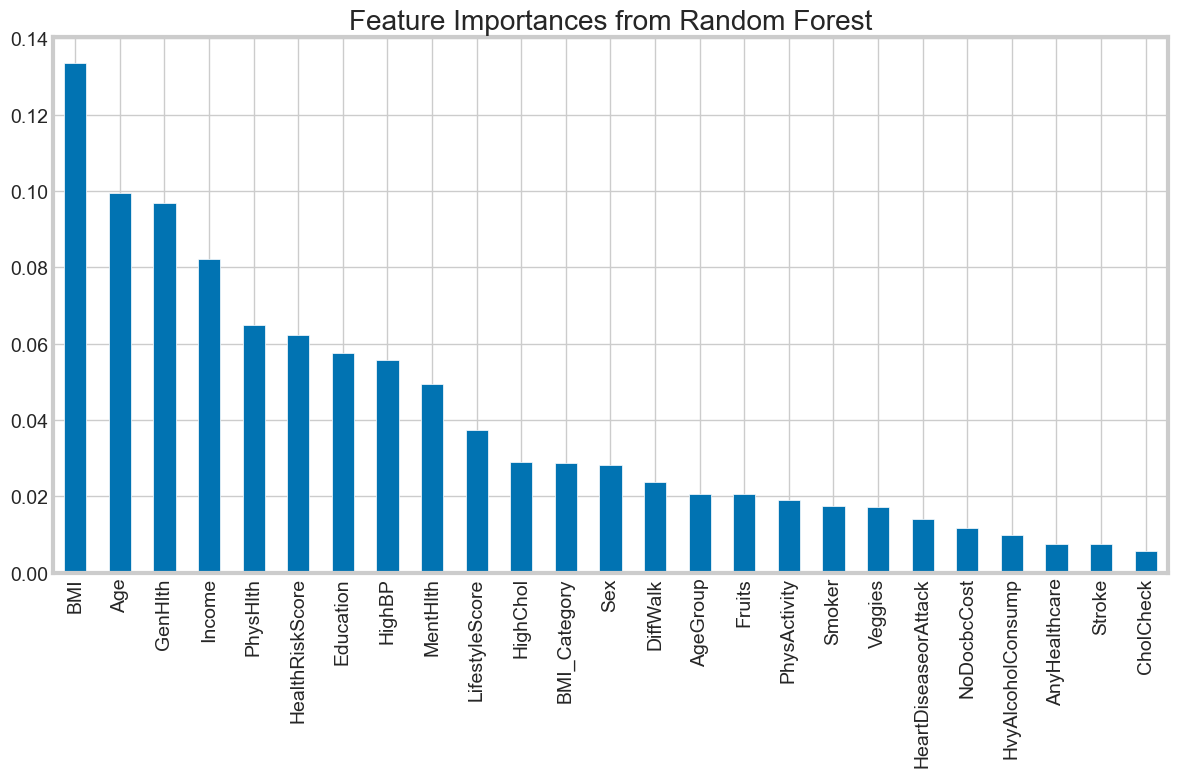

Selected features: ['HighBP', 'HighChol', 'BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Sex', 'Age', 'Education', 'Income', 'BMI_Category', 'HealthRiskScore', 'LifestyleScore']
Original feature count: 25
Selected feature count: 13


In [23]:
# Feature Selection with Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Ensure X_train_scaled is properly typed as DataFrame
try:
    # Make sure X_train_scaled is a DataFrame with columns
    if not isinstance(X_train_scaled, pd.DataFrame):
        print("Converting X_train_scaled to DataFrame")
        X_train_scaled = pd.DataFrame(X_train_scaled)
        
    if not isinstance(X_test_scaled, pd.DataFrame):
        print("Converting X_test_scaled to DataFrame")
        X_test_scaled = pd.DataFrame(X_test_scaled)
        
    # Train a Random Forest for feature importance
    print("Training Random Forest for feature selection...")
    rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_selector.fit(X_train_scaled, y_train)
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    if hasattr(X_train_scaled, 'columns'):
        importances = pd.Series(rf_selector.feature_importances_, index=X_train_scaled.columns)
    else:
        importances = pd.Series(rf_selector.feature_importances_)
    importances = importances.sort_values(ascending=False)
    importances.plot.bar()
    plt.title('Feature Importances from Random Forest')
    plt.tight_layout()
    plt.show()
    
    # Select top features
    selector = SelectFromModel(rf_selector, threshold='median')
    selector.fit(X_train_scaled, y_train)
    
    # Get selected features
    if hasattr(X_train_scaled, 'columns'):
        selected_features = X_train_scaled.columns[selector.get_support()]
        print("Selected features:", selected_features.tolist())
    else:
        selected_indices = np.where(selector.get_support())[0]
        print("Selected feature indices:", selected_indices.tolist())
    
    # Create datasets with selected features only
    X_train_selected = selector.transform(X_train_scaled)
    X_test_selected = selector.transform(X_test_scaled)
    
    # Convert to DataFrame if needed
    if not isinstance(X_train_selected, pd.DataFrame):
        if hasattr(X_train_scaled, 'columns'):
            selected_cols = X_train_scaled.columns[selector.get_support()].tolist()
            X_train_selected = pd.DataFrame(X_train_selected, columns=selected_cols)
            X_test_selected = pd.DataFrame(X_test_selected, columns=selected_cols)
    
    print(f"Original feature count: {X_train_scaled.shape[1]}")
    print(f"Selected feature count: {X_train_selected.shape[1] if hasattr(X_train_selected, 'shape') else 'unknown'}")

except Exception as e:
    print(f"Error in feature selection: {e}")
    # Create fallback selected datasets in case of error
    X_train_selected = X_train_scaled
    X_test_selected = X_test_scaled
    print("Using all features due to error in feature selection.")

# We'll use both the full feature set and the selected feature set for modeling


## Modeling

In this section, we'll build several machine learning models:
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. Support Vector Machine (SVM)
5. XGBoost (if available)

We'll evaluate each model's performance using cross-validation and compare them on the test set.


In [ ]:
# Define a helper function for model evaluation
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # ROC-AUC score (if probability estimates are available)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Return results
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    return results

# Create a dictionary to store model results
model_results = {}

# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Add XGBoost if available
if has_xgb:
    models['XGBoost'] = XGBClassifier(random_state=42)
    print("XGBoost added to models.")
else:
    print("XGBoost not available, skipping.")

# Train and evaluate models with all features
print("Evaluating models with all features...")
for name, model in models.items():
    try:
        print(f"Training {name}...")
        results = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
        model_results[f"{name} (all features)"] = results
        
        # Print key metrics
        print(f"{name} - Accuracy: {results['accuracy']:.4f}, F1: {results['f1_score']:.4f}, ROC-AUC: {results.get('roc_auc', 'N/A')}")
    except Exception as e:
        print(f"Error training {name}: {e}")
        # Add a placeholder result to avoid breaking later code
        model_results[f"{name} (all features)"] = {
            'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0,
            'roc_auc': None, 'confusion_matrix': np.array([[0, 0], [0, 0]])
        }

# Train and evaluate models with selected features
print("\nEvaluating models with selected features...")
for name, model in models.items():
    try:
        print(f"Training {name} with selected features...")
        results = evaluate_model(model, X_train_selected, X_test_selected, y_train, y_test)
        model_results[f"{name} (selected features)"] = results
        
        # Print key metrics
        print(f"{name} - Accuracy: {results['accuracy']:.4f}, F1: {results['f1_score']:.4f}, ROC-AUC: {results.get('roc_auc', 'N/A')}")
    except Exception as e:
        print(f"Error training {name} with selected features: {e}")
        model_results[f"{name} (selected features)"] = {
            'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0,
            'roc_auc': None, 'confusion_matrix': np.array([[0, 0], [0, 0]])
        }


XGBoost added to models.
Evaluating models with all features...
Training Logistic Regression...
Logistic Regression - Accuracy: 0.7466, F1: 0.7567, ROC-AUC: 0.8181774309645333
Training Decision Tree...


c:\Users\asus\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Decision Tree - Accuracy: 0.6477, F1: 0.6523, ROC-AUC: 0.6472212574538841
Training Random Forest...
Random Forest - Accuracy: 0.7242, F1: 0.7388, ROC-AUC: 0.7974272459806913
Training SVM...


In [1]:
# Create a summary of model performance
model_summary = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [results['accuracy'] for results in model_results.values()],
    'Precision': [results['precision'] for results in model_results.values()],
    'Recall': [results['recall'] for results in model_results.values()],
    'F1 Score': [results['f1_score'] for results in model_results.values()],
    'ROC AUC': [results['roc_auc'] if results['roc_auc'] is not None else np.nan 
               for results in model_results.values()]
})

# Sort by F1 score (or another metric of interest)
model_summary = model_summary.sort_values('F1 Score', ascending=False)

# Display the summary table
model_summary


NameError: name 'pd' is not defined

In [ ]:
# Visualize model performance with bar charts
try:
    plt.figure(figsize=(14, 8))
    
    # Metrics to plot
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    n_models = len(model_summary)
    n_metrics = len(metrics)
    
    # Set up the bar positions
    bar_width = 0.2
    positions = np.arange(n_models)
    
    # Plot bars for each metric
    for i, metric in enumerate(metrics):
        plt.bar(positions + i * bar_width, model_summary[metric], 
                width=bar_width, label=metric)
    
    # Customize the plot
    plt.title('Model Performance Comparison', fontsize=15)
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    
    # Fix the xticks type error by converting to list
    plt.xticks(positions + bar_width * (n_metrics - 1) / 2, 
               model_summary['Model'].tolist(), rotation=45, ha='right')
    plt.legend()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
except Exception as e:
    print(f"Error in model performance visualization: {e}")

# Plot confusion matrix for the best model
try:
    # Check if we have valid model results
    if len(model_summary) > 0:
        best_model_name = model_summary.iloc[0]['Model']
        best_model_cm = model_results[best_model_name]['confusion_matrix']
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(best_model_cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No Diabetes', 'Diabetes'],
                    yticklabels=['No Diabetes', 'Diabetes'])
        plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        # Calculate classification report for the best model
        model_name = best_model_name.split(' (')[0]  # Extract base model name
        feature_set = 'all features' if '(all features)' in best_model_name else 'selected features'
        
        if model_name in models:
            best_model = models[model_name]
            
            # Determine which feature set to use
            if feature_set == 'all features':
                X_train_best = X_train_scaled
                X_test_best = X_test_scaled
            else:
                X_train_best = X_train_selected
                X_test_best = X_test_selected
            
            # Retrain best model and generate classification report
            best_model.fit(X_train_best, y_train)
            y_pred_best = best_model.predict(X_test_best)
            print(f"Classification Report - {best_model_name}:\n")
            print(classification_report(y_test, y_pred_best, target_names=['No Diabetes', 'Diabetes']))
        else:
            print(f"Error: Model {model_name} not found in models dictionary")
    else:
        print("No model results available to visualize")
except Exception as e:
    print(f"Error in confusion matrix or classification report: {e}")


In [ ]:
# Plot ROC curves for models
plt.figure(figsize=(10, 8))

# Select only models with ROC AUC scores (those that provide probability estimates)
models_with_roc = [name for name, results in model_results.items() if results['roc_auc'] is not None]

for model_name in models_with_roc:
    # Get model
    base_name = model_name.split(' (')[0]
    feature_set = 'all features' if '(all features)' in model_name else 'selected features'
    model = models[base_name]
    
    # Use appropriate feature set
    if feature_set == 'all features':
        X_test_features = X_test_scaled
    else:
        X_test_features = X_test_selected
    
    # Get probabilities and compute ROC curve
    if hasattr(model, 'predict_proba'):
        model.fit(X_train_best, y_train)  # Fit model
        y_proba = model.predict_proba(X_test_features)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')

# Add labels and legend
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves', fontsize=15)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# For interpretability, let's look at feature importance from our best model
# We'll use Random Forest for feature importance regardless of which model performed best
# Get a new Random Forest model
rf_interpret = RandomForestClassifier(n_estimators=100, random_state=42)
rf_interpret.fit(X_train_scaled, y_train)

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': rf_interpret.feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
plt.title('Top 15 Most Important Features', fontsize=15)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# Try to use SHAP if available
try:
    import shap
    # Create a SHAP explainer
    explainer = shap.TreeExplainer(rf_interpret)
    
    # Calculate SHAP values (use a sample of the test set for efficiency)
    shap_sample = X_test_scaled.sample(500, random_state=42)
    shap_values = explainer.shap_values(shap_sample)
    
    # Plot the SHAP summary plot
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, shap_sample, plot_type='bar', show=False)
    plt.title('SHAP Feature Importance', fontsize=15)
    plt.tight_layout()
    plt.show()
    
    # Plot SHAP summary plot (beeswarm)
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, shap_sample, show=False)
    plt.title('SHAP Summary Plot', fontsize=15)
    plt.tight_layout()
    plt.show()
    
    # SHAP dependence plots for top features
    top_features = feature_importance['Feature'].head(3).values
    for feature in top_features:
        plt.figure(figsize=(10, 7))
        shap.dependence_plot(feature, shap_values, shap_sample, show=False)
        plt.title(f'SHAP Dependence Plot for {feature}', fontsize=15)
        plt.tight_layout()
        plt.show()
        
except ImportError:
    print("SHAP not available for interpretability. Using feature importance plots only.")
